In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cpp_wrappers
import FRCfuncs
import os
import copy
import ImageManipulation as IM
from importlib import reload

<module 'ImageManipulation' from 'K:\\vanderVoortN\\FRC\\Code\\ImageManipulation.py'>

In [2]:
def saveGRYIm(RGYobj, outfolder, preposition = '', xmin = 0, xmax = -1, ymin = 0, ymax = -1): 
    #convert all strings to bytes
    try: outfolder = outfolder.encode()
    except: pass
    try: preposition = preposition.encode()
    except: pass
    try:
        os.mkdir(outfolder)
        print('creating new folder %s\n' %os.path.join(outfolder))
    except: 'folder already exists'
    im = Image.fromarray(RGYobj.G[xmin:xmax, ymin:ymax])
    outname = os.path.join(outfolder, preposition + b'imG.tif').decode()
    im.save(outname)
    im = Image.fromarray(RGYobj.R[xmin:xmax, ymin:ymax])
    outname = os.path.join(outfolder, preposition + b'imR.tif').decode()
    im.save(outname)
    im = Image.fromarray(RGYobj.Y[xmin:xmax, ymin:ymax])
    outname = os.path.join(outfolder, preposition + b'imY.tif').decode()
    im.save(outname)
    return 0

In [8]:
a = np.zeros(10)
type(a)

numpy.ndarray

header dir already exists
b'N:\\Singlem\\singlem19-3\\August\\05_Origami_NV_AB_JHB\\completely labelled\\header\\Origami_TLMR_33_ROXS.txt'
number of records is 265287
N:\Singlem\singlem19-3\August\05_Origami_NV_AB_JHB\completely labelled\header\Origami_TLMR_33_ROXS.txt


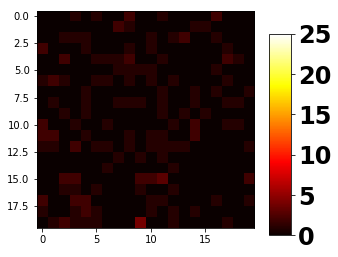

In [86]:

f12 = b'Origami_TLMR_12_ROXS.ptu'
f33 = b'Origami_TLMR_33_ROXS.ptu'
fname = f12
wdir = b'N:\\Singlem\\singlem19-3\\August\\05_Origami_NV_AB_JHB\\completely labelled'

fname = os.path.join(wdir, fname)

obj = processLifetimeImage(fname, uselines = np.array([1,1,1,2]))
outdir = ''
obj.loadLifetime()
obj.gate(26, 200)
obj.loadIntensity()
intIm = obj.getIntensity()

obj.loadLifetime()
obj.gate(26, 200)
obj.filterLifetime('smear_lifetime', 3)
obj.meanArrivalTime(26, 54)
ltIm = obj.getIntensity()
saveGRYIm(ltIm, os.path.join(wdir, b'TLMR12_snips'), 'lt', 31, 51, 80, 100)
saveGRYIm(intIm, os.path.join(wdir, b'TLMR12_snips'), '', 31, 51, 80, 100)

fg_color = 'black'
cmap = cm.hot
cmap.set_over(color='green')
cmap.set_under(color='black')
plt.imshow(intIm.Y[31:51,80:100], vmin = 0, vmax = 25, cmap = cmap)
fig = plt.gcf()
cbaxes = fig.add_axes([0.8, 0.1, 0.05, 0.7])  
cbar = plt.colorbar(orientation = 'vertical', fraction = 2, aspect = 7, cax = cbaxes)
cbar.ax.yaxis.set_tick_params(color=fg_color)
cbar.outline.set_edgecolor(fg_color)

cbar.ax.set_yticklabels([0,5,10,15,20,25], fontsize=24, weight='bold')
cbytick_obj = plt.getp(cbar.ax.axes, 'yticklabels')                #tricky
plt.setp(cbytick_obj, color='w')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color=fg_color)
fig.patch.set_facecolor([0,0,0,0]) 
plt.savefig('20190816sniptest.png', dpi = 300, transparent = True)

In [3]:
from PIL import Image
from matplotlib import cm
wdir = b'N:\\Singlem\\singlem19-3\\August\\05_Origami_NV_AB_JHB\\completely labelled'
f6 = b'Origami_TLMR_6_ROXS.ptu'
f8 = b'Origami_TLMR_8_ROXS.ptu'
f12 = b'Origami_TLMR_12_ROXS.ptu'
f16 = b'Origami_TLMR_16_ROXS.ptu'
f20 = b'Origami_TLMR_20_ROXS.ptu'
f23 = b'Origami_TLMR_23_ROXS.ptu'
f24 = b'Origami_TLMR_24_ROXS.ptu'
f30 = b'Origami_TLMR_30_ROXS.ptu'
f33 = b'Origami_TLMR_33_ROXS.ptu'
f35 = b'Origami_TLMR_35_ROXS.ptu'
f36 = b'Origami_TLMR_36_ROXS.ptu'
f37 = b'Origami_TLMR_37_ROXS.ptu'
f44 = b'Origami_TLMR_44_ROXS.ptu'
f48 = b'Origami_TLMR_48_ROXS.ptu'
f51 = b'Origami_TLMR_51_ROXS.ptu'
f52 = b'Origami_TLMR_52_ROXS.ptu'
f59 = b'Origami_TLMR_59_ROXS.ptu'
f63 = b'Origami_TLMR_63_ROXS.ptu'
f67 = b'Origami_TLMR_67_ROXS.ptu'
f68 = b'Origami_TLMR_68_ROXS.ptu'
f69 = b'Origami_TLMR_69_ROXS.ptu'
#f = [f6, f8, f12, f16, f20, f23, f24, f30, f33, f35, f36, f37, f44, f48, f51, f52, f59, f63, f67, f68, f69]
f = [f12]
fnames = []
for el in f:
    fnames.append(os.path.join(wdir, el))
for fname in fnames:
    print(b'processing ' + fname[-20:])
    obj = processLifetimeImage(fname, uselines = np.array([1,1,1,2]))
    obj.loadLifetime()
    obj.gate(26, 200)
    obj.loadIntensity()
    intIm = obj.getIntensity()  
    obj.loadLifetime()
    obj.gate(26, 200)
    obj.filterLifetime('smear_lifetime', 3)
    obj.meanArrivalTime(26, 54)
    ltIm = obj.getIntensity()
    
    #save images
    saveim(intIm.G, fname, b'\\imG.tiff')
    saveim(intIm.R, fname, b'\\imR.tiff')
    saveim(intIm.Y, fname, b'\\imY.tiff')
    saveim(ltIm.G, fname, b'\\ltG.tiff')
    saveim(ltIm.R, fname, b'\\ltR.tiff')
    saveim(ltIm.Y, fname, b'\\ltY.tiff')
    
    #fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    cmap = cm.hot
    cmap.set_over(color='green')
    cmap.set_under(color='blue')
    plt.imshow(intIm.Y[31:51,80:100], vmin = 1, vmax = 25, cmap = cmap)
    plt.colorbar()
    plt.show


b'processing ami_TLMR_12_ROXS.ptu'
header dir already exists
b'N:\\Singlem\\singlem19-3\\August\\05_Origami_NV_AB_JHB\\completely labelled\\header\\Origami_TLMR_12_ROXS.txt'
number of records is 248836
N:\Singlem\singlem19-3\August\05_Origami_NV_AB_JHB\completely labelled\header\Origami_TLMR_12_ROXS.txt


NameError: name 'saveim' is not defined

In [110]:
IM = reload(IM)

In [111]:
roifile = 'CLR9_Yellow Photons.roi'
file = 'CLR9.ptu'
wdir = r'N:\Singlem\singlem19-4\october\18_CLR_origamis_NV\ensemble_exc561_50pct_exc640_5pct_STED40pct'

fname = os.path.join(wdir, file).encode()
CLR = IM.processLifetimeImage(fname, uselines = np.array([1,2]), ntacs = 1024)
CLR.loadLifetime()
#CLR.gate(32,150)
CLR.loadIntensity()

header dir already exists
b'N:\\Singlem\\singlem19-4\\october\\18_CLR_origamis_NV\\ensemble_exc561_50pct_exc640_5pct_STED40pct\\header\\CLR9.txt'
number of records is 3495674
N:\Singlem\singlem19-4\october\18_CLR_origamis_NV\ensemble_exc561_50pct_exc640_5pct_STED40pct\header\CLR9.txt


0

In [116]:
ROIDir = r'N:\Singlem\singlem19-4\october\18_CLR_origamis_NV\ensemble_exc561_50pct_exc640_5pct_STED40pct\sub_ensemble_sep\NF_population\Pixel numbers of selected ROIs'
roifile = r'CLR9_Frames   0- 99_Green_Fit#23__MinPh# 0_MaxPh# Inf_0_ROI size ±3.roi'

ROIS = np.genfromtxt(os.path.join(ROIDir,roifile)).astype(np.int32)
mask = IM.processLifetimeImage.buildMaskFromROI(CLR, ROIS)
CLR.mask(mask, mode = 'lifetime')
CLR.sumLifetime()

0

In [117]:
CLR.sumLifetime()
CLR.decay.G

0

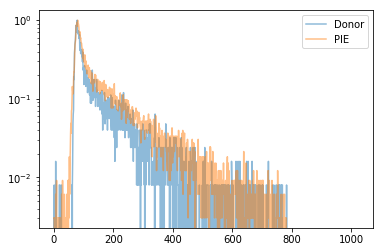

In [124]:
plt.plot(CLR.decay.G / max(CLR.decay.G), label = 'Donor', alpha = 0.5)
plt.plot(CLR.decay.Y / max(CLR.decay.Y), label = 'PIE', alpha = 0.5)
plt.legend()
ax = plt.gca()
ax.set_yscale('log')